In [1]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import s3fs
import scipy
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

sys.path.append("/Users/fgu/dev/projects/entropy")
import entropy.data.aggregators as ag
import entropy.data.cleaners as cl
import entropy.data.make_data as md
import entropy.data.selectors as sl
import entropy.data.validators as vl
import entropy.helpers.aws as ha
import entropy.helpers.data as hd
import entropy.helpers.helpers as hh

pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)
pd.set_option("max_colwidth", None)
%load_ext autoreload
%autoreload 2

fs = s3fs.S3FileSystem(profile="3di")

In [58]:
df = hd.read_txn_data("777")
hd.inspect(df)

Time for read_txn_data                 : 2.57 seconds
(651,789, 21)


,date,user_id,amount,desc,merchant,tag_group,tag,account_id,account_last_refreshed,account_provider,account_type,debit,female,id,is_urban,latest_balance,logins,postcode,region_name,tag_auto,yob
0,2012-02-01,777,400.00,<mdbremoved> - s/o,NaN,transfers,other_transfers,262916,2020-07-21 20:32:00,natwest bank,current,True,0.0,688300,1.0,364.220001,0.0,wa1 4,north west,transfers,1969.0
1,2012-02-01,777,3.03,aviva pa - d/d,aviva,spend,finance,262916,2020-07-21 20:32:00,natwest bank,current,True,0.0,688299,1.0,364.220001,0.0,wa1 4,north west,health insurance,1969.0


## Role of zero counts

In [3]:
month = pd.Grouper(key="date", freq="m")
idx_cols = ["user_id", month]


def zero_tag_count(df):
    is_cat_observed_spend = df.tag_group.eq("spend") & df.debit & df.tag.notna()
    df = df.loc[is_cat_observed_spend].copy()
    group_cols = idx_cols + ["tag"]
    return (
        df.groupby(group_cols, observed=True)
        .size()
        .unstack()
        .fillna(0)
        .eq(0)
        .sum(1)
        .rename("zero_count")
    )

In [4]:
dfe = pd.concat([ag.count_based_entropy_scores(df), zero_tag_count(df)], axis=1)
dfe.head(3)

Time for count_based_entropy_scores    : 14.70 seconds


entropy_tag_wsz  entropy_tag_ws  entropy_tag_wz  \
user_id date                                                          
777     2012-02-29         0.661028        3.809216       -0.109933   
        2012-04-30         1.490783        4.012188       -0.175010   
        2012-05-31         0.820016        3.848107        0.872784   

                    entropy_tag_w  entropy_tag_sz  entropy_tag_s  \
user_id date                                                       
777     2012-02-29       2.765957        0.852658       2.829955   
        2012-04-30       2.721928        1.622524       3.036372   
        2012-05-31       3.430832        0.665282       2.779716   

                    entropy_tag_z  entropy_tag  entropy_tag_auto_wsz  \
user_id date                                                           
777     2012-02-29       0.358315     2.333206              0.956184   
        2012-04-30       0.702472     2.521928              1.117354   
        2012-05-31       0.763935     2.555632              0.411889   

                    entropy_tag_auto_ws  entropy_tag_auto_wz  \
user_id date                                                   
777     2012-02-29             8.133265            -0.064284   
        2012-04-30             8.159651            -1.028432   
        2012-05-31             8.044156             0.539796   

                    entropy_tag_auto_w  entropy_tag_auto_sz  \
user_id date                                                  
777     2012-02-29            3.621928             1.037420   
        2012-04-30            2.721928             1.244908   
        2012-05-31            4.185816             0.331154   

                    entropy_tag_auto_s  entropy_tag_auto_z  entropy_tag_auto  \
user_id date                                                                   
777     2012-02-29            7.133471            0.124506          3.284184   
        2012-04-30            7.192627           -0.534020          2.721928   
        2012-05-31            6.932112            0.475841          3.584157   

                    entropy_merchant_wsz  entropy_merchant_ws  \
user_id date                                                    
777     2012-02-29              0.722775            10.733970   
        2012-04-30              0.917772            10.739614   
        2012-05-31              0.464962            10.726507   

                    entropy_merchant_wz  entropy_merchant_w  \
user_id date                                                  
777     2012-02-29            -0.585837            3.202820   
        2012-04-30            -1.236689            2.521641   
        2012-05-31             0.688261            4.536286   

                    entropy_merchant_sz  entropy_merchant_s  \
user_id date                                                  
777     2012-02-29             0.782676            9.786762   
        2012-04-30             0.950548            9.797387   
        2012-05-31             0.512267            9.769647   

                    entropy_merchant_z  entropy_merchant  zero_count  
user_id date                                                          
777     2012-02-29           -0.255450          3.202820           3  
        2012-04-30           -0.949911          2.521641           3  
        2012-05-31            0.907257          4.343289           1

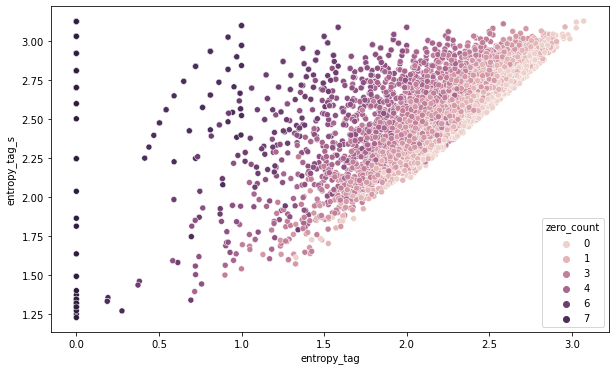

In [7]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(y="entropy_tag_s", x="entropy_tag", hue="zero_count", data=dfe, alpha=1);

## Counts exploration

In [ ]:
def random_user_counts(df):
    user = df.user_id.sample(1).values[0]
    return (
        df.loc[df.tag_group.eq("spend") & df.debit]
        .groupby(["user_id", df.date.dt.to_period("m"), "tag_auto"], observed=True)
        .size()
        .unstack()
        .fillna(0)
    ).loc[user]


random_user_counts(df).tail(10)

tag_auto,health insurance,"entertainment, tv, media",gambling,cash,"food, groceries, household",insurance,fuel,home appliance insurance,lunch or snacks,mobile,interest charges,personal electronics,transport,appearance,jewellery,beauty products,"medical, dental, eye care",accessories,diy,books / magazines / newspapers,"child - toys, clubs or other",cinema,life insurance,dining or going out,pet - everyday or food,dining and drinking,photography,stationery,service / parts / repairs,enjoyment,home diy or repairs,home,breakdown cover,vehicle insurance,gym membership,dental treatment,mortgage or rent,gifts or presents,public transport,parking,appliances or electrical,clothes - everyday or work,bank charges,sports equipment,tv licence,toys,children - other,"energy (gas, elec, other)",hotel/b&b,eye care,software,payment protection insurance,holiday,one-off or other,shoes,council tax,banking charges,water,zoo/theme park,"hairdressing, health, other",...,donation to organisation,hire purchase,child - clothes,clothes - designer or other,hairdressing,flights,road charges,alcohol,taxi,fines,pet insurance,supermarket,unsecured loan repayment,one-off or other payment,child - everyday or childcare,dry cleaning and laundry,administration - other,vehicle running costs,clothes,taxis or vehicle hire,vet,"pet - toys, training, other",home insurance,driving lessons,web hosting,vehicle tax,repayments,payday loan,toiletries,course and tuition fees,insurance - other,dental insurance,electricity,gas,sports club membership,school fees,social club,printing,furniture,personal care - other,art,sports event,device rental,household - other,spa,student loan repayment,media bundle,designer clothes,musical equipment,education - other,sharedealing account,groceries,store card repayment,hobby club membership,hobby supplies,childcare fees,childrens club fees,medical treatment,secured loan repayment,coal/oil/lpg/other
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-12,0.0,0.0,0.0,7.0,11.0,0.0,6.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01,0.0,1.0,0.0,8.0,7.0,0.0,5.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-02,0.0,3.0,0.0,7.0,16.0,0.0,8.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-03,0.0,0.0,0.0,4.0,9.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [74]:
def counts(df):
    return (
        df.loc[df.tag_group.eq("spend") & df.debit]
        .groupby(["user_id", df.date.dt.to_period("m"), "tag"], observed=True)
        .size()
        .unstack()
        .fillna(0)
    )


c = counts(df)
c.groupby("user_id").describe().describe().round(2).T

count   mean    std  min    25%    50%    75%     max
tag                                                                       
finance       count  278.0  26.53  19.82  1.0  11.00  23.00  38.00  100.00
              mean   278.0   3.87   4.25  0.0   1.00   2.83   5.04   32.49
              std    273.0   2.30   3.07  0.0   0.67   1.35   2.56   21.70
              min    278.0   1.37   2.12  0.0   0.00   1.00   2.00   13.00
              25%    278.0   2.46   3.43  0.0   0.00   1.50   3.19   30.00
              50%    278.0   3.27   3.95  0.0   1.00   2.00   4.50   33.00
              75%    278.0   4.78   5.67  0.0   1.31   3.00   6.00   39.50
              max    278.0   9.83  11.84  0.0   3.00   7.00  11.00   76.00
services      count  278.0  26.53  19.82  1.0  11.00  23.00  38.00  100.00
              mean   278.0  15.39  10.86  0.0   8.01  12.98  20.05   75.00
              std    273.0   7.66   5.23  0.0   4.13   6.46   9.42   28.40
              min    278.0   4.85   6.95  0.0   0.00   3.00   7.00   50.00
              25%    278.0  10.40   9.53  0.0   4.00   8.50  14.00   65.25
              50%    278.0  14.30  10.91  0.0   7.00  12.00  19.00   73.50
              75%    278.0  19.55  13.22  0.0  10.81  17.00  25.00   83.00
              max    278.0  32.21  21.42  0.0  17.00  27.50  40.75  117.00
other_spend   count  278.0  26.53  19.82  1.0  11.00  23.00  38.00  100.00
              mean   278.0   4.93   3.40  0.0   2.50   4.05   6.70   19.39
              std    273.0   2.85   1.94  0.0   1.77   2.44   3.42   17.38
              min    278.0   1.29   2.30  0.0   0.00   0.00   2.00   16.00
              25%    278.0   3.01   2.92  0.0   1.00   2.50   4.00   16.00
              50%    278.0   4.53   3.52  0.0   2.00   4.00   6.00   20.50
              75%    278.0   6.50   4.35  0.0   3.75   6.00   8.88   31.00
              max    278.0  11.02   7.14  0.0   6.00  10.00  14.00   51.00
household     count  278.0  26.53  19.82  1.0  11.00  23.00  38.00  100.00
              mean   278.0  14.69  10.14  0.0   7.05  12.72  20.12   51.47
              std    273.0   6.70   4.20  0.0   3.97   6.01   8.57   26.28
              min    278.0   4.88   6.51  0.0   0.00   2.00   8.00   40.00
              25%    278.0  10.39   9.22  0.0   3.00   8.50  15.38   44.00
              50%    278.0  14.13  10.90  0.0   6.00  12.00  20.00   54.00
              75%    278.0  18.38  12.19  0.0   9.75  16.50  25.00   66.00
              max    278.0  28.48  17.16  0.0  16.00  26.00  38.00   98.00
motor         count  278.0  26.53  19.82  1.0  11.00  23.00  38.00  100.00
              mean   278.0   2.32   2.32  0.0   0.43   1.57   3.44   12.16
              std    273.0   1.69   1.42  0.0   0.71   1.46   2.36    7.97
              min    278.0   0.43   1.25  0.0   0.00   0.00   0.00    7.00
              25%    278.0   1.20   1.74  0.0   0.00   0.25   2.00    8.00
              50%    278.0   1.97   2.34  0.0   0.00   1.00   3.00   12.00
              75%    278.0   3.08   3.13  0.0   0.00   2.00   5.00   18.00
              max    278.0   6.25   5.30  0.0   2.00   5.50   9.00   30.00
communication count  278.0  26.53  19.82  1.0  11.00  23.00  38.00  100.00
              mean   278.0   1.91   1.45  0.0   1.00   1.68   2.61    9.40
              std    273.0   0.89   0.76  0.0   0.43   0.74   1.19    4.97
              min    278.0   0.78   1.05  0.0   0.00   0.00   1.00    7.00
              25%    278.0   1.36   1.25  0.0   0.50   1.00   2.00    8.00
              50%    278.0   1.78   1.48  0.0   1.00   1.00   2.50   10.00
              75%    278.0   2.31   1.78  0.0   1.00   2.00   3.00   11.00
              max    278.0   3.95   2.98  0.0   2.00   3.00   5.00   19.00
retail        count  278.0  26.53  19.82  1.0  11.00  23.00  38.00  100.00
              mean   278.0   3.62   2.86  0.0   1.47   2.88   4.91   16.73
              std    273.0   2.63   1.77  0.0   1.48   2.22   3.54   15.47
              min    278.0   0.66   1.51  0.0 

<AxesSubplot:xlabel='date'>

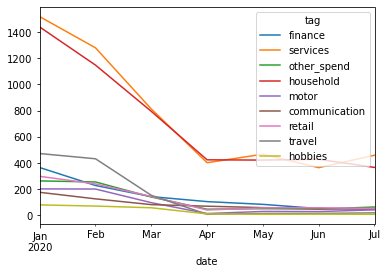

In [78]:
c.groupby("date").sum().loc["2020"].plot()